# COVID-19 Predictions

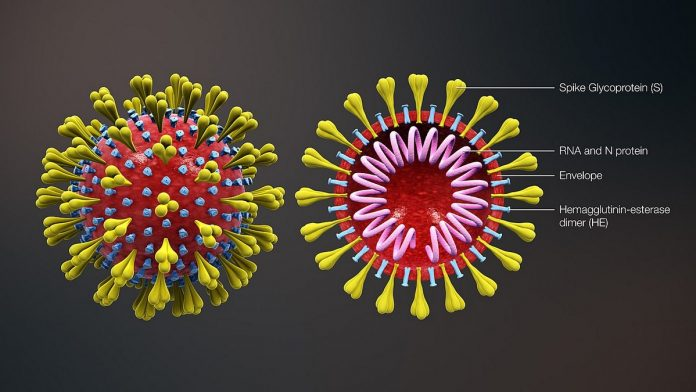

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Input, Conv2D, MaxPooling2D,GlobalMaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Activation, MaxPool2D, AvgPool2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import DenseNet121, VGG19, ResNet50
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from IPython.display import display, Image
import matplotlib.pyplot as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import warnings
warnings.filterwarnings("ignore")

from sklearn.utils import shuffle

## Loading dataset


In [2]:
train_df = pd.read_csv('/home/aditya/coronaV_Xray_prediction/dataset/Chest_xray_Corona_Metadata.csv')
valid_df = pd.read_csv('/home/aditya/coronaV_Xray_prediction/dataset/Chest_xray_Corona_dataset_Summary.csv')

print('The training dataset has rows : ', format(train_df.shape[0]))
print('The training dataset has cols : ', format(train_df.shape[1]))

The training dataset has rows :  5910
The training dataset has cols :  6


In [3]:
train_df.head(5)

Unnamed: 0   X_ray_image_name   Label Dataset_type Label_2_Virus_category  \
0           0  IM-0128-0001.jpeg  Normal        TRAIN                    NaN   
1           1  IM-0127-0001.jpeg  Normal        TRAIN                    NaN   
2           2  IM-0125-0001.jpeg  Normal        TRAIN                    NaN   
3           3  IM-0122-0001.jpeg  Normal        TRAIN                    NaN   
4           4  IM-0119-0001.jpeg  Normal        TRAIN                    NaN   

  Label_1_Virus_category  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN

### Missing Values

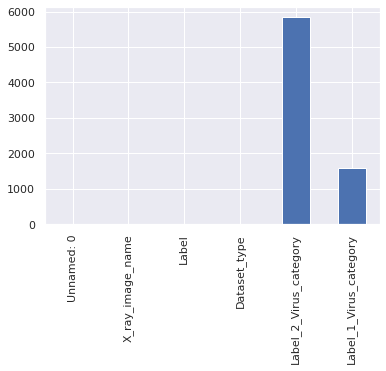

In [19]:
missing_vals = train_df.isnull().sum()
missing_vals.plot(kind = 'bar')

In [4]:
train_df.dropna(how = 'all')
train_df.isnull().sum()

Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5841
Label_1_Virus_category    1576
dtype: int64

In [21]:
train_data = train_df[train_df['Dataset_type'] == 'TRAIN']
test_data = train_df[train_df['Dataset_type'] == 'TEST']
assert train_data.shape[0] + test_data.shape[0] == train_df.shape[0]
print(f"Shape of train data : {train_data.shape}")
print(f"Shape of test data : {test_data.shape}")
test_data.sample(10)

Shape of train data : (5286, 6)
Shape of test data : (624, 6)


Unnamed: 0             X_ray_image_name     Label Dataset_type  \
5570        5593  person147_bacteria_711.jpeg  Pnemonia         TEST   
5789        5812      person67_virus_126.jpeg  Pnemonia         TEST   
5502        5525    NORMAL2-IM-0359-0001.jpeg    Normal         TEST   
5726        5749   person92_bacteria_451.jpeg  Pnemonia         TEST   
5771        5794      person78_virus_140.jpeg  Pnemonia         TEST   
5472        5495    NORMAL2-IM-0112-0001.jpeg    Normal         TEST   
5414        5437    NORMAL2-IM-0285-0001.jpeg    Normal         TEST   
5622        5645  person130_bacteria_627.jpeg  Pnemonia         TEST   
5838        5861       person23_virus_56.jpeg  Pnemonia         TEST   
5577        5600  person145_bacteria_696.jpeg  Pnemonia         TEST   

     Label_2_Virus_category Label_1_Virus_category  
5570                    NaN               bacteria  
5789                    NaN                  Virus  
5502                    NaN                    NaN  
5726                    NaN               bacteria  
5771                    NaN                  Virus  
5472                    NaN                    NaN  
5414                    NaN                    NaN  
5622                    NaN               bacteria  
5838                    NaN                  Virus  
5577                    NaN               bacteria

In [22]:
train_fill = train_data.fillna('unknown')
test_fill = test_data.fillna('unknown')
display(train_fill.head(5))

Unnamed: 0   X_ray_image_name   Label Dataset_type Label_2_Virus_category  \
0           0  IM-0128-0001.jpeg  Normal        TRAIN                unknown   
1           1  IM-0127-0001.jpeg  Normal        TRAIN                unknown   
2           2  IM-0125-0001.jpeg  Normal        TRAIN                unknown   
3           3  IM-0122-0001.jpeg  Normal        TRAIN                unknown   
4           4  IM-0119-0001.jpeg  Normal        TRAIN                unknown   

  Label_1_Virus_category  
0                unknown  
1                unknown  
2                unknown  
3                unknown  
4                unknown

### visualization of unknown data

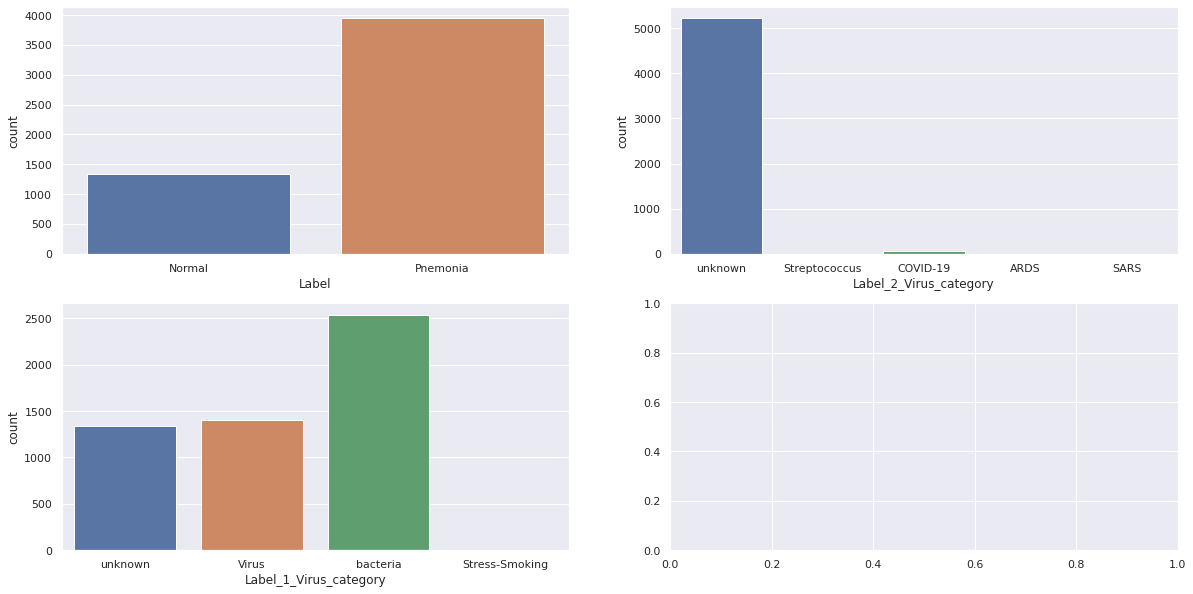

In [27]:
# Count plot for 3 attributes with unknown variable addition
targets = ['Label', 'Label_2_Virus_category', 'Label_1_Virus_category']
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.countplot(x=targets[0], data=train_fill, ax=ax[0, 0])
sns.countplot(x=targets[1], data=train_fill, ax=ax[0, 1])
sns.countplot(x=targets[2], data=train_fill, ax=ax[1, 0])
plt.show()

### Display Images

In [38]:
test_img_dir = '/home/aditya/coronaV_Xray_prediction/dataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
train_img_dir = '/home/aditya/coronaV_Xray_prediction/dataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'

assert os.path.isdir(test_img_dir) == True
assert os.path.isdir(train_img_dir) == True

sample_train_images = list(os.walk(train_img_dir))[0][2][:8]
sample_train_images = list(map(lambda x: os.path.join(train_img_dir, x), sample_train_images))

sample_test_images = list(os.walk(test_img_dir))[0][2][:8]
sample_test_images = list(map(lambda x: os.path.join(test_img_dir, x), sample_test_images))

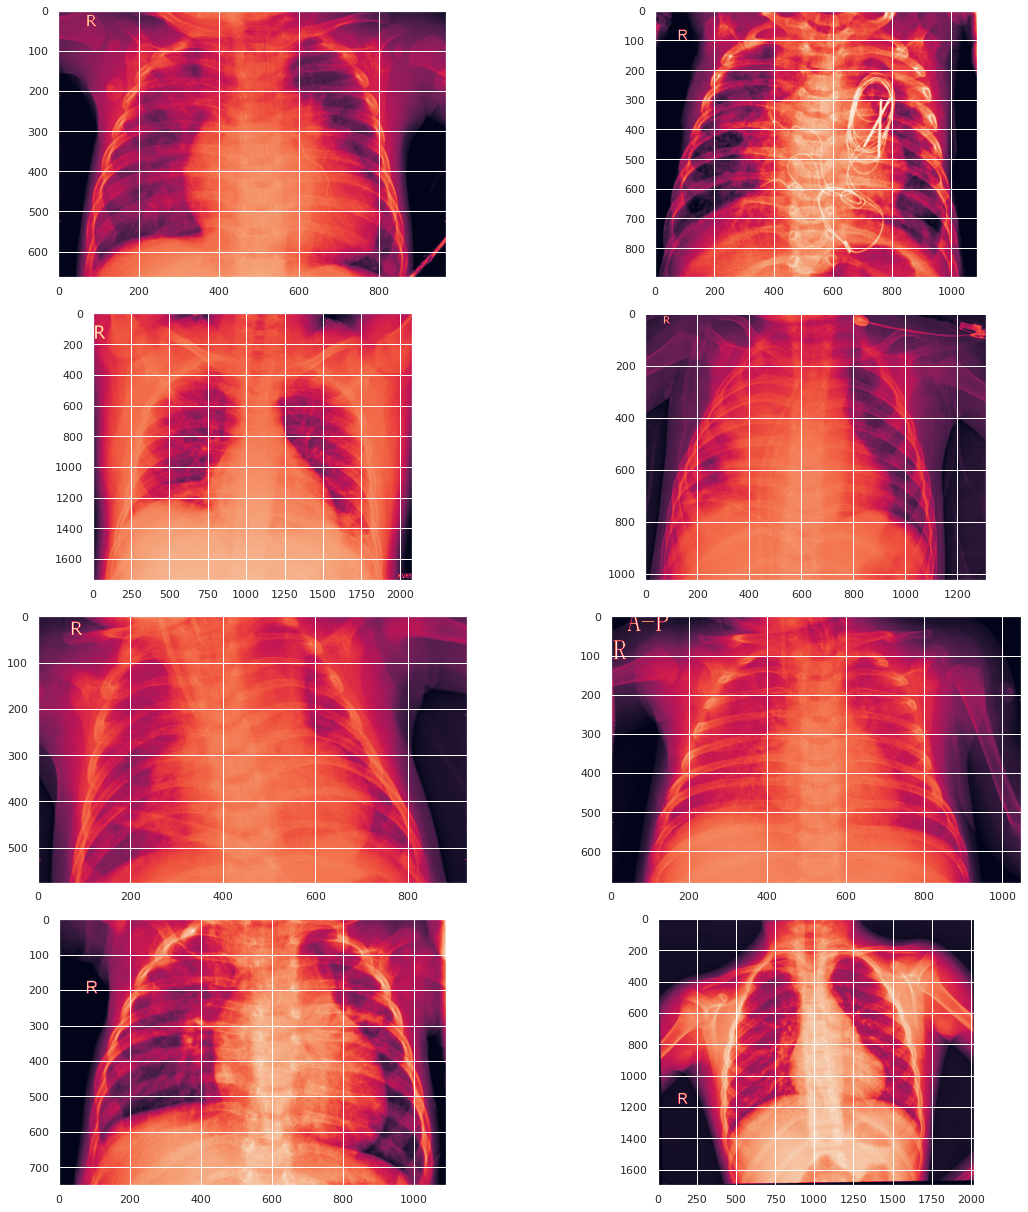

In [39]:
from PIL import Image
plt.figure(figsize = (17,17))
for iterator, filename in enumerate(sample_train_images):
    image = Image.open(filename)
    plt.subplot(4,2,iterator+1)
    plt.imshow(image)

plt.tight_layout()

Display test images

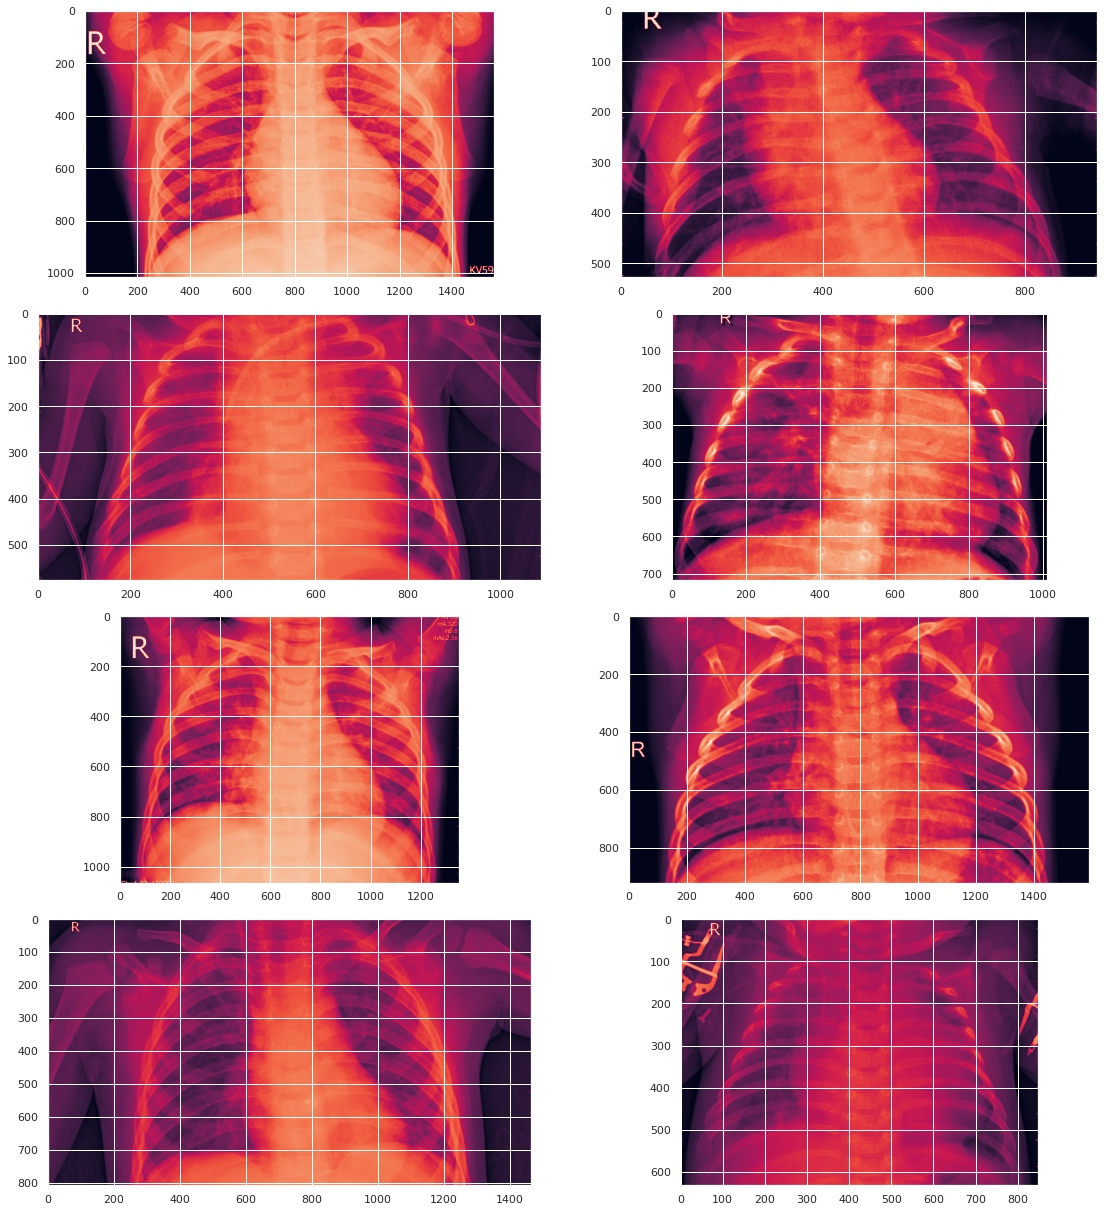

In [40]:
plt.figure(figsize = (17,17))
for iterator, filename in enumerate(sample_test_images):
    image = Image.open(filename)
    plt.subplot(4,2,iterator+1)
    plt.imshow(image)

plt.tight_layout()

### Histogram analysis of Images
 - for covid-19 cases

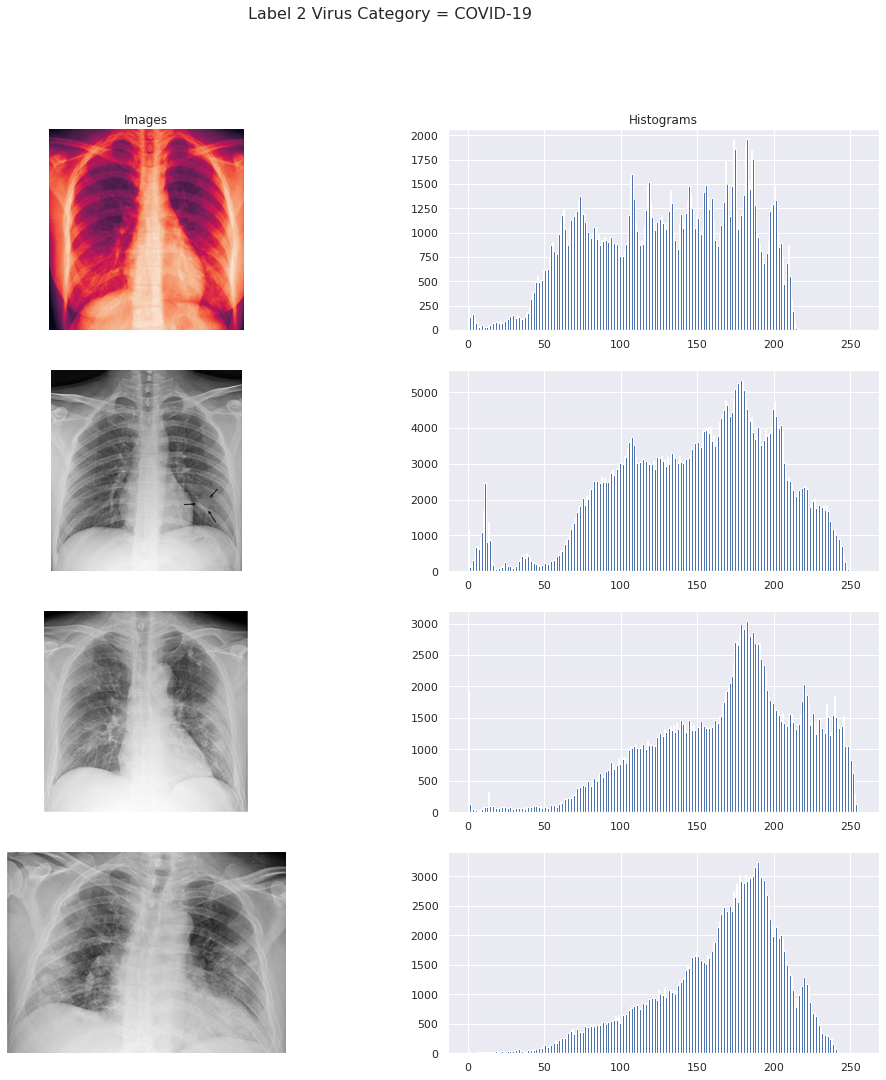

In [41]:
fig, ax = plt.subplots(4, 2, figsize=(17, 17))


covid_path = train_data[train_data['Label_2_Virus_category']=='COVID-19']['X_ray_image_name'].values

sample_covid_path = covid_path[:4]
sample_covid_path = list(map(lambda x: os.path.join(train_img_dir, x), sample_covid_path))

for row, file in enumerate(sample_covid_path):
    image = plt.imread(file)
    ax[row, 0].imshow(image)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Label 2 Virus Category = COVID-19', size=16)
plt.show()

###### Normal histogram images

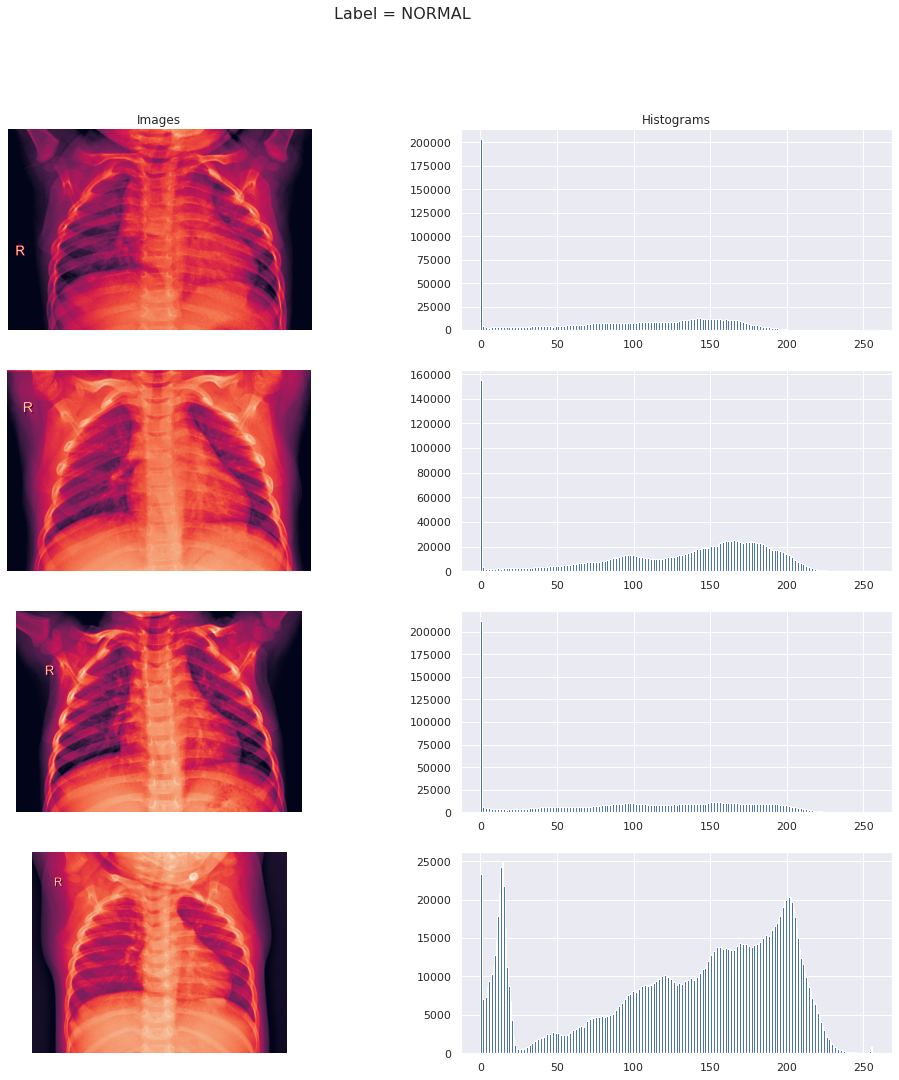

In [42]:
fig, ax = plt.subplots(4, 2, figsize=(17, 17))


normal_path = train_data[train_data['Label']=='Normal']['X_ray_image_name'].values

sample_normal_path = normal_path[:4]
sample_normal_path = list(map(lambda x: os.path.join(train_img_dir, x), sample_normal_path))

for row, file in enumerate(sample_normal_path):
    image = plt.imread(file)
    ax[row, 0].imshow(image)
    ax[row, 1].hist(image.ravel(), 256, [0,256])
    ax[row, 0].axis('off')
    if row == 0:
        ax[row, 0].set_title('Images')
        ax[row, 1].set_title('Histograms')
fig.suptitle('Label = NORMAL', size=16)
plt.show()

## Image Augmentation

In [43]:
final_train_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') & (train_data['Label_2_Virus_category'] == 'COVID-19'))]


# Create a target attribute where value = positive if 'Pnemonia + COVID-19' or value = negative if 'Normal'
final_train_data['target'] = ['negative' if holder == 'Normal' else 'positive' for holder in final_train_data['Label']]

final_train_data = shuffle(final_train_data, random_state=1)

final_validation_data = final_train_data.iloc[1000:, :]
final_train_data = final_train_data.iloc[:1000, :]

print(f"Final train data shape : {final_train_data.shape}")
final_train_data.sample(10)

Final train data shape : (1000, 7)


Unnamed: 0           X_ray_image_name     Label Dataset_type  \
101          101          IM-0250-0001.jpeg    Normal        TRAIN   
1208        1208  NORMAL2-IM-1177-0001.jpeg    Normal        TRAIN   
1109        1109  NORMAL2-IM-1054-0001.jpeg    Normal        TRAIN   
5229        5238              gr1_lrg-a.jpg  Pnemonia        TRAIN   
937          937  NORMAL2-IM-0904-0001.jpeg    Normal        TRAIN   
1011        1011  NORMAL2-IM-0952-0001.jpeg    Normal        TRAIN   
1299        1299  NORMAL2-IM-1294-0001.jpeg    Normal        TRAIN   
701          701  NORMAL2-IM-0507-0001.jpeg    Normal        TRAIN   
161          161          IM-0353-0001.jpeg    Normal        TRAIN   
808          808  NORMAL2-IM-0675-0001.jpeg    Normal        TRAIN   

     Label_2_Virus_category Label_1_Virus_category    target  
101                     NaN                    NaN  negative  
1208                    NaN                    NaN  negative  
1109                    NaN                    NaN  negative  
5229               COVID-19                  Virus  positive  
937                     NaN                    NaN  negative  
1011                    NaN                    NaN  negative  
1299                    NaN                    NaN  negative  
701                     NaN                    NaN  negative  
161                     NaN                    NaN  negative  
808                     NaN                    NaN  negative

In [51]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.5,
)

test_image_generator = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_train_data,
    directory=train_img_dir,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=16,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

validation_generator = train_image_generator.flow_from_dataframe(
    dataframe=final_validation_data,
    directory=train_img_dir,
    x_col='X_ray_image_name',
    y_col='target',
    target_size=(224, 224),
    batch_size=16,
    seed=2020,
    shuffle=True,
    class_mode='binary'
)

test_generator = test_image_generator.flow_from_dataframe(
    dataframe=test_data,
    directory=test_img_dir,
    x_col='X_ray_image_name',
    target_size=(224, 224),
    shuffle=False,
    batch_size=16,
    class_mode=None)

Found 1000 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.
Found 624 validated image filenames.


## Model Development

In [52]:
IMG_W = 224
IMG_H = 224
CHANNELS = 3

INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NB_CLASSES = 2
EPOCHS = 30
BATCH_SIZE = 6

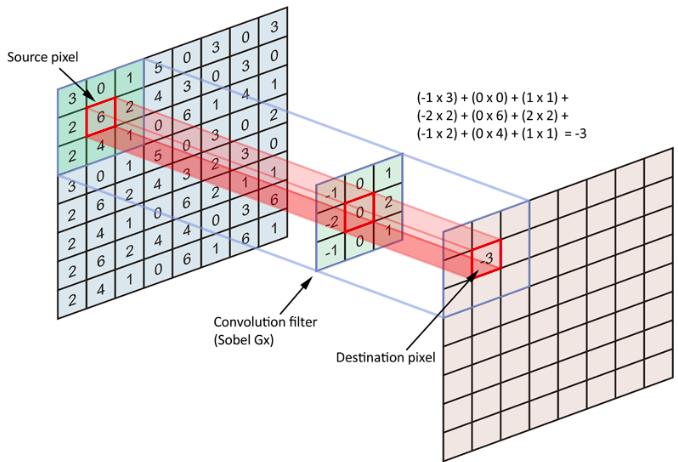
### Convolutional Neural Network

In [53]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(Conv2D(250,(3,3)))
model.add(Activation("relu"))
  
model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))

model.add(Conv2D(256,(2,2)))
model.add(Activation("relu"))
model.add(MaxPool2D(2,2))
    
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation("sigmoid"))

In [54]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
activation_34 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_35 (Activation)   (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 52, 52, 64)       

In [55]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.9325):
            print("\nReached 94.25% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

In [56]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = model.fit_generator(train_generator,
                              steps_per_epoch = len(train_generator),
                   validation_data=validation_generator,
                   epochs=15,
                             validation_steps=len(validation_generator))

Epoch 1/15
63/63 [==============================] - 124s 2s/step - loss: 0.5150 - accuracy: 0.9650 - val_loss: 0.2918 - val_accuracy: 0.9425
Epoch 2/15
63/63 [==============================] - 117s 2s/step - loss: 0.1607 - accuracy: 0.9650 - val_loss: 0.2026 - val_accuracy: 0.9425
Epoch 3/15
63/63 [==============================] - 119s 2s/step - loss: 0.1558 - accuracy: 0.9650 - val_loss: 0.2493 - val_accuracy: 0.9425
Epoch 4/15
63/63 [==============================] - 116s 2s/step - loss: 0.1614 - accuracy: 0.9650 - val_loss: 0.2287 - val_accuracy: 0.9425
Epoch 5/15
63/63 [==============================] - 116s 2s/step - loss: 0.1516 - accuracy: 0.9650 - val_loss: 0.1933 - val_accuracy: 0.9425
Epoch 6/15
63/63 [==============================] - 119s 2s/step - loss: 0.1583 - accuracy: 0.9650 - val_loss: 0.2288 - val_accuracy: 0.9425
Epoch 7/15
63/63 [==============================] - 115s 2s/step - loss: 0.1676 - accuracy: 0.9650 - val_loss: 0.2205 - val_accuracy: 0.9425
Epoch 8/15
63

###### Plot to estimate loss and accuracy

Text(0.5, 1.0, 'Metrics estimations')

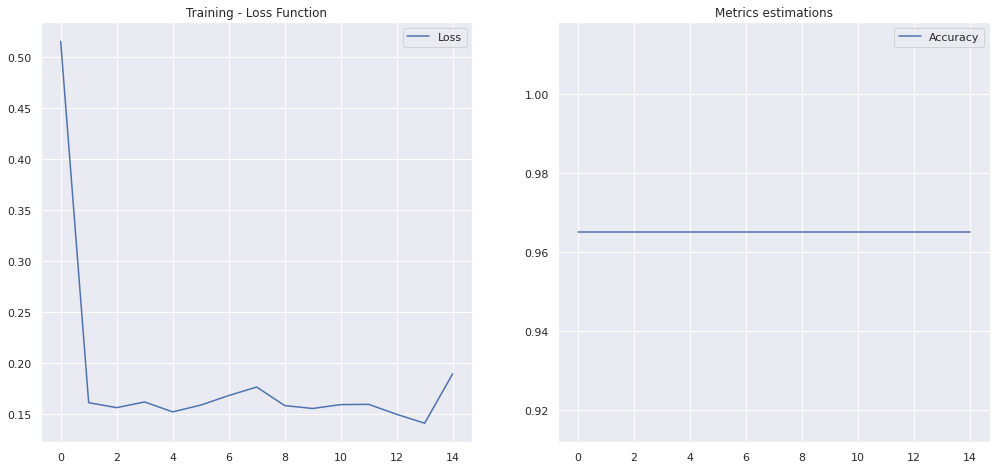

In [57]:
plt.figure(figsize=(17,17))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.legend()
plt.title('Train - Accuracy')

plt.legend()
plt.title('Metrics estimations')

In [58]:
model.save('cnn_model.h5')

## Transfer Learning

### DenseNet121

In [59]:
dense_model = Sequential()
dense_model.add(DenseNet121(include_top=False, pooling = 'avg', weights='imagenet',input_shape=(224, 224, 3), classes=2))
dense_model.add(Dense(2, activation='softmax'))
dense_model.layers[0].trainable = False
dense_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

29089792/29084464 [==============================] - 15s 1us/step


In [60]:
dense_history = dense_model.fit_generator(train_generator,
                              #steps_per_epoch = 150
                   validation_data=validation_generator,
                   epochs=15
                             #validation_steps=30
                                         )

Epoch 1/15
63/63 [==============================] - 121s 2s/step - loss: 0.7630 - accuracy: 0.4930 - val_loss: 0.7334 - val_accuracy: 0.6000
Epoch 2/15
63/63 [==============================] - 118s 2s/step - loss: 0.7269 - accuracy: 0.5140 - val_loss: 0.7203 - val_accuracy: 0.3925
Epoch 3/15
63/63 [==============================] - 118s 2s/step - loss: 0.7159 - accuracy: 0.5000 - val_loss: 0.7090 - val_accuracy: 0.4900
Epoch 4/15
63/63 [==============================] - 118s 2s/step - loss: 0.7097 - accuracy: 0.5010 - val_loss: 0.7077 - val_accuracy: 0.3850
Epoch 5/15
63/63 [==============================] - 118s 2s/step - loss: 0.7094 - accuracy: 0.5050 - val_loss: 0.7041 - val_accuracy: 0.4150
Epoch 6/15
63/63 [==============================] - 117s 2s/step - loss: 0.7043 - accuracy: 0.4760 - val_loss: 0.7023 - val_accuracy: 0.5050
Epoch 7/15
63/63 [==============================] - 115s 2s/step - loss: 0.7024 - accuracy: 0.4970 - val_loss: 0.6995 - val_accuracy: 0.6050
Epoch 8/15
63

Text(0.5, 1.0, 'Train - Accuracy')

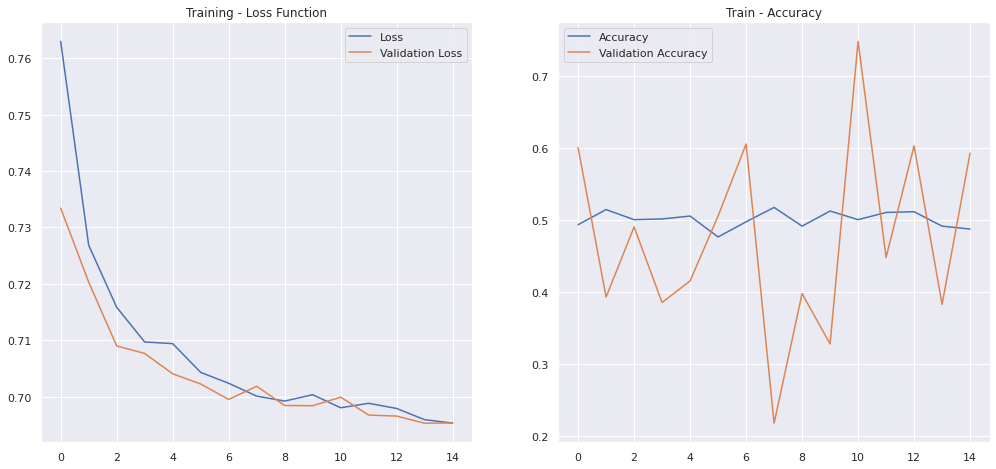

In [61]:
plt.figure(figsize=(17,17))

plt.subplot(2, 2, 1)
plt.plot(dense_history.history['loss'], label='Loss')
plt.plot(dense_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(dense_history.history['accuracy'], label='Accuracy')
plt.plot(dense_history.history['val_accuracy'], label='Validation Accuracy')

plt.legend()
plt.title('Train - Accuracy')

In [63]:
model.save('densenet_model.h5')

## MobileNetV2

In [62]:
mob_model = Sequential()
mob_model.add(tf.keras.applications.MobileNetV2(include_top=False, pooling = 'avg', weights='imagenet',input_shape=(224, 224, 3), classes=2))
mob_model.add(Dense(2, activation='softmax'))
mob_model.layers[0].trainable = False
mob_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

9412608/9406464 [==============================] - 2s 0us/step


In [64]:
mob_history = mob_model.fit_generator(train_generator,
                              #steps_per_epoch = 150,
                   validation_data=validation_generator,
                   epochs=15
                             #validation_steps=30
                                     )

Epoch 1/15
63/63 [==============================] - 68s 1s/step - loss: 0.7431 - accuracy: 0.5090 - val_loss: 0.7304 - val_accuracy: 0.6125
Epoch 2/15
63/63 [==============================] - 55s 874ms/step - loss: 0.7243 - accuracy: 0.4940 - val_loss: 0.7220 - val_accuracy: 0.5900
Epoch 3/15
63/63 [==============================] - 52s 828ms/step - loss: 0.7147 - accuracy: 0.5020 - val_loss: 0.7115 - val_accuracy: 0.5150
Epoch 4/15
63/63 [==============================] - 52s 833ms/step - loss: 0.7089 - accuracy: 0.4850 - val_loss: 0.7075 - val_accuracy: 0.5200
Epoch 5/15
63/63 [==============================] - 64s 1s/step - loss: 0.7082 - accuracy: 0.5090 - val_loss: 0.7074 - val_accuracy: 0.4300
Epoch 6/15
63/63 [==============================] - 57s 903ms/step - loss: 0.7062 - accuracy: 0.5110 - val_loss: 0.7054 - val_accuracy: 0.4300
Epoch 7/15
63/63 [==============================] - 56s 889ms/step - loss: 0.7027 - accuracy: 0.4840 - val_loss: 0.7016 - val_accuracy: 0.5125
Epoch

Text(0.5, 1.0, 'Train - Accuracy')

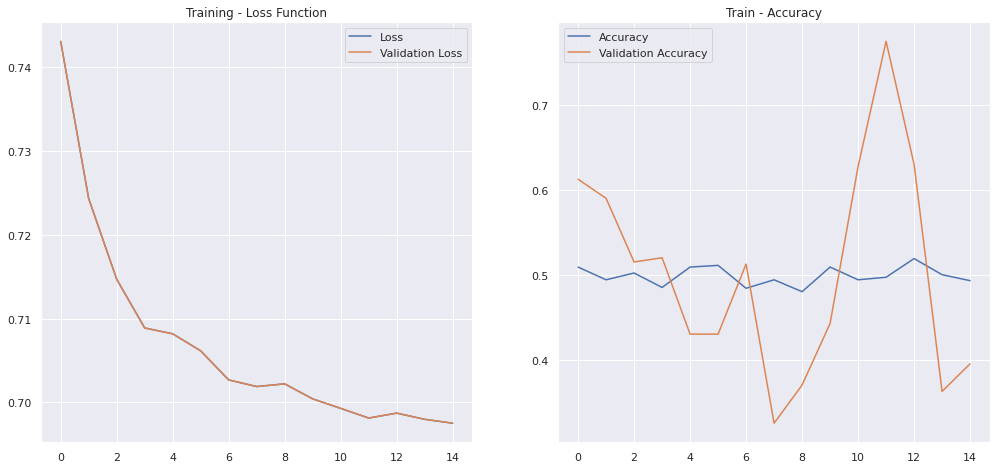

In [65]:
plt.figure(figsize=(17,17))

plt.subplot(2, 2, 1)
plt.plot(mob_history.history['loss'], label='Loss')
plt.plot(mob_history.history['loss'], label='Validation Loss')

plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(mob_history.history['accuracy'], label='Accuracy')
plt.plot(mob_history.history['val_accuracy'], label='Validation Accuracy')


plt.legend()
plt.title('Train - Accuracy')

In [66]:
model.save('mob_net.h5')

In [67]:
model.predict(validation_generator)

array([[0.05944899],
       [0.05865663],
       [0.0604831 ],
       [0.05723274],
       [0.05975655],
       [0.05752936],
       [0.05896491],
       [0.0523718 ],
       [0.05768153],
       [0.05495515],
       [0.05874389],
       [0.05981201],
       [0.06237507],
       [0.05742708],
       [0.05856383],
       [0.05395645],
       [0.05907807],
       [0.0537014 ],
       [0.05809855],
       [0.05893645],
       [0.05849615],
       [0.05630648],
       [0.0581916 ],
       [0.05952877],
       [0.05395311],
       [0.06031477],
       [0.05855206],
       [0.05992711],
       [0.05762401],
       [0.057787  ],
       [0.05914718],
       [0.05960134],
       [0.05929318],
       [0.059163  ],
       [0.05373868],
       [0.05939528],
       [0.05816704],
       [0.05480763],
       [0.05737743],
       [0.05843836],
       [0.05691501],
       [0.06002408],
       [0.05944598],
       [0.0599227 ],
       [0.05733085],
       [0.05700356],
       [0.0597364 ],
       [0.057

In [68]:
dense_model.predict(validation_generator)

array([[0.5723808 , 0.4276192 ],
       [0.496396  , 0.50360405],
       [0.47809395, 0.5219061 ],
       [0.47696713, 0.52303284],
       [0.45491004, 0.54509   ],
       [0.5446782 , 0.45532173],
       [0.51191616, 0.4880838 ],
       [0.47973442, 0.5202656 ],
       [0.50387865, 0.49612138],
       [0.5208627 , 0.47913733],
       [0.49258816, 0.50741184],
       [0.59507835, 0.40492168],
       [0.49533787, 0.50466216],
       [0.54321545, 0.45678452],
       [0.5163667 , 0.48363325],
       [0.43714952, 0.5628504 ],
       [0.49856728, 0.5014327 ],
       [0.500973  , 0.49902698],
       [0.5588383 , 0.44116166],
       [0.5757787 , 0.42422122],
       [0.49062753, 0.5093724 ],
       [0.5514273 , 0.44857273],
       [0.476477  , 0.5235229 ],
       [0.50896734, 0.49103272],
       [0.50014484, 0.49985516],
       [0.5393914 , 0.4606086 ],
       [0.5297817 , 0.47021827],
       [0.48774964, 0.51225036],
       [0.5142629 , 0.48573714],
       [0.55863833, 0.4413617 ],
       [0.

In [69]:
mob_model.predict(validation_generator)

array([[0.4614437 , 0.53855634],
       [0.5173303 , 0.4826697 ],
       [0.5094247 , 0.49057525],
       [0.51393044, 0.48606956],
       [0.55239683, 0.4476031 ],
       [0.49820265, 0.5017973 ],
       [0.5377755 , 0.46222442],
       [0.55085295, 0.44914702],
       [0.4954881 , 0.50451183],
       [0.4935864 , 0.5064136 ],
       [0.47406137, 0.5259386 ],
       [0.5156955 , 0.4843045 ],
       [0.46351847, 0.5364815 ],
       [0.44366816, 0.5563318 ],
       [0.48338288, 0.51661706],
       [0.5717132 , 0.42828676],
       [0.455823  , 0.544177  ],
       [0.53885585, 0.46114412],
       [0.42986175, 0.5701382 ],
       [0.49723753, 0.50276244],
       [0.47138697, 0.528613  ],
       [0.45978597, 0.540214  ],
       [0.5798231 , 0.42017695],
       [0.49076626, 0.5092338 ],
       [0.5396353 , 0.46036464],
       [0.5137129 , 0.48628706],
       [0.48547834, 0.51452166],
       [0.5372473 , 0.46275273],
       [0.5340343 , 0.4659657 ],
       [0.48660094, 0.51339906],
       [0.

In [70]:
label = validation_generator.classes

## CNN Predictions

In [71]:
pred= model.predict(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print (labels)
print (predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
{'negative': 0, 'positive': 1}
['negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 

In [72]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(predicted_class_indices,label)
cf_matrix

array([[377,  23],
       [  0,   0]])

In [73]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class_indices)
pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

Predicted    0  All
Actual             
0          377  377
1           23   23
All        400  400

## DenseNet Predictions

In [74]:
pred= dense_model.predict(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print (labels)
print (predictions)

[0 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 1 1
 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0
 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1
 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0
 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0
 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1]
{'negative': 0, 'positive': 1}
['negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 

In [75]:
cf_matrix = confusion_matrix(predicted_class_indices,label)
cf_matrix

array([[246,   9],
       [131,  14]])

In [76]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class_indices)
pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

Predicted    0    1  All
Actual                  
0          246  131  377
1            9   14   23
All        255  145  400

## MobileNet Predictions


In [77]:
pred= mob_model.predict(validation_generator)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print (labels)
print (predictions)

[1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0
 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1
 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 1
 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1
 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0
 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1
 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1
 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1
 1 0 0 1 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 0 0 1
 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 0]
{'negative': 0, 'positive': 1}
['positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 

In [78]:
cf_matrix = confusion_matrix(predicted_class_indices,label)
cf_matrix

array([[155,   9],
       [222,  14]])

In [79]:
exp_series = pd.Series(label)
pred_series = pd.Series(predicted_class_indices)
pd.crosstab(exp_series, pred_series, rownames=['Actual'], colnames=['Predicted'],margins=True)

Predicted    0    1  All
Actual                  
0          155  222  377
1            9   14   23
All        164  236  400

#### Predicting for a random Image for CNN model

In [6]:
cnn_model = keras.models.load_model('cnn_model.h5')

In [7]:
from keras.preprocessing.image import img_to_array,load_img
import matplotlib.pyplot as plt
%matplotlib inline
def pred(img_path):    
    img = load_img(img_path,target_size = (224,224))
    x = img_to_array(img) 
    x = np.expand_dims(x,axis=0) 
    p = np.argmax(cnn_model.predict(x))
    if p==0:     
        print("Negetive")
    elif p==1:
        print("Positive")


Negetive


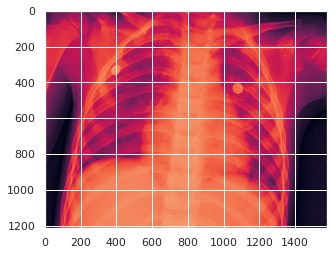

In [8]:
pred("/home/aditya/covid-19_project_final_year/Xray_images/img23.jpeg")
z = plt.imread('/home/aditya/covid-19_project_final_year/Xray_images/img23.jpeg') 
plt.imshow(z); 

#### Predicting for random image for DesnseNet-121

In [35]:
dense_model = keras.models.load_model('densenet_model.h5')

In [36]:
from keras.preprocessing.image import img_to_array,load_img
import matplotlib.pyplot as plt
%matplotlib inline
def pred(img_path):    
    img = load_img(img_path,target_size = (224,224))
    x = img_to_array(img) 
    x = np.expand_dims(x,axis=0) 
    p = np.argmax(dense_model.predict(x))
    if p==0:     
        print("Negetive")
    elif p==1:
        print("Positive")

Negetive


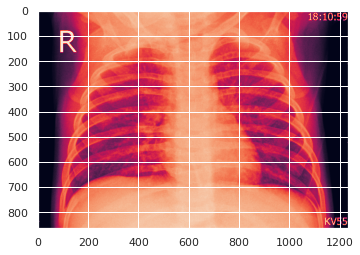

In [48]:
pred("/home/aditya/covid-19_project_final_year/Xray_images/img21.jpeg")
z = plt.imread('/home/aditya/covid-19_project_final_year/Xray_images/img21.jpeg') 
plt.imshow(z); 